In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"

import calendar

import pandas as pd
import numpy as np 
import seaborn as sns
# import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim
import nltk
import os
import re
import spacy
import matplotlib.pyplot as plt
import string
import math
import copy

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from ydata_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from itertools import chain
from typing import List, Tuple
from pprint import pprint
from joblib import Parallel
from joblib import delayed
from IPython.display import Image
from statistics import mean
from gensim.models import Word2Vec

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


# Data Understanding

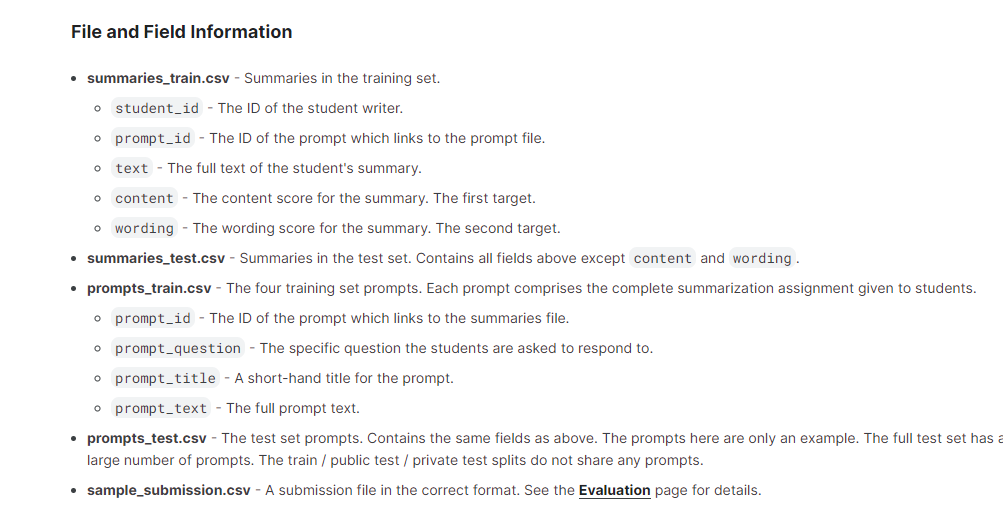

In [51]:
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")

## Explore data

In [52]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [53]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [54]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [55]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [56]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [57]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

In [58]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [59]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [60]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [61]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [62]:
# Joining summaries_train and prompts_train on "prompt_id"
merged_train = pd.merge(summaries_train, prompts_train, on="prompt_id", how="inner")
merged_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

# EDA

In [63]:
profile = ProfileReport(merged_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# We see that content has a high correlation with wording, so it would be useful to study it further

Text(0.5, 1.0, 'Content distribution')

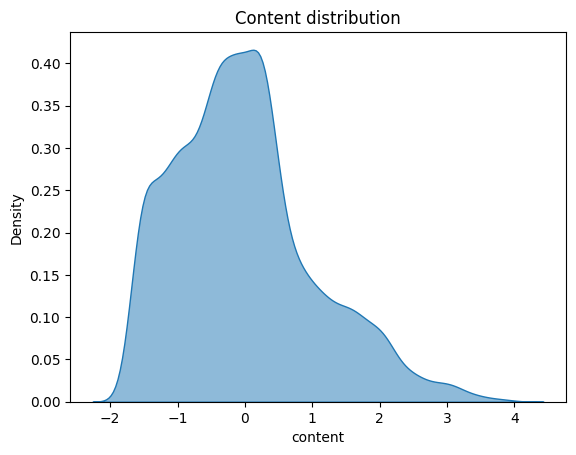

In [64]:
sns.kdeplot(data=merged_train, x="content", alpha=.5, fill=True)
plt.title("Content distribution")

Text(0.5, 1.0, 'Wording Score distribution')

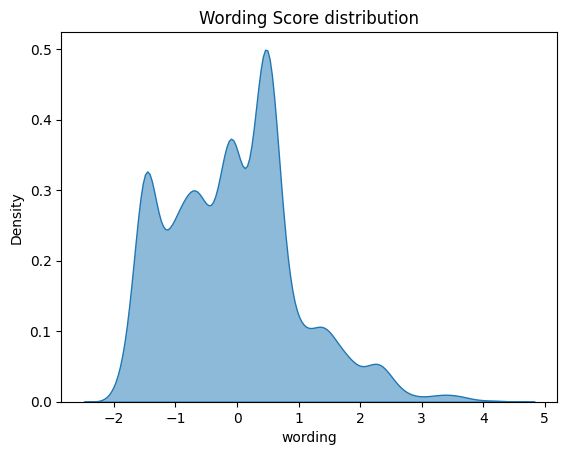

In [65]:
sns.kdeplot(data=merged_train, x="wording", alpha=.5, fill=True)
plt.title("Wording Score distribution")

<Axes: xlabel='content', ylabel='wording'>

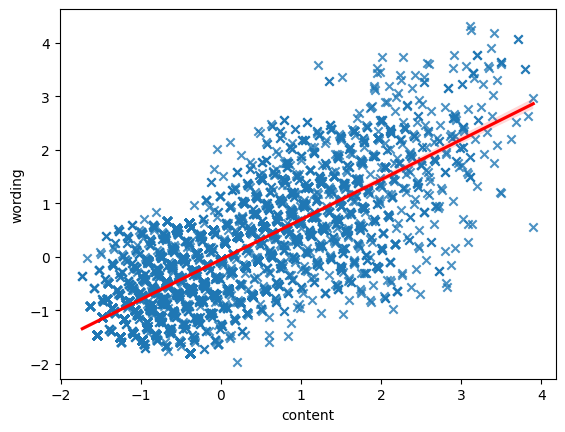

In [66]:
sns.regplot(
    data=merged_train, x="content", y="wording",
    ci=99, marker="x", line_kws=dict(color="r"),
)

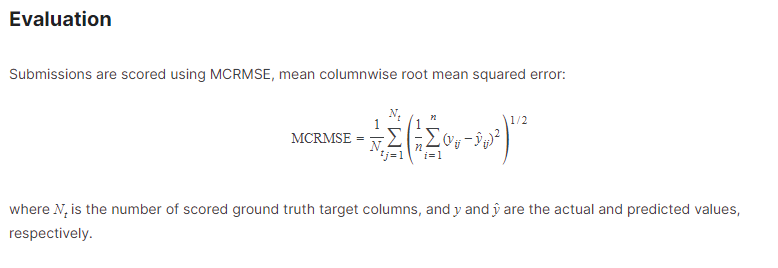

## Word clouds for summaries grouped by four distinct titles

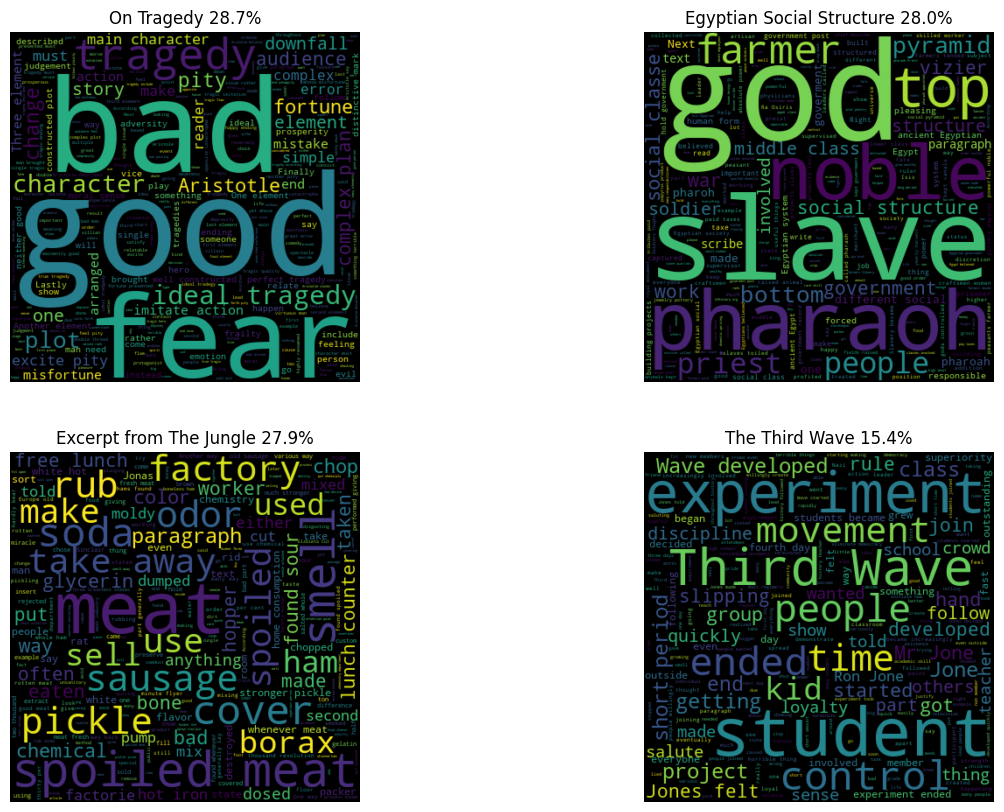

In [67]:
plt.figure(figsize = (15, 10))
for ind, title_percent in enumerate(zip(["On Tragedy", "Egyptian Social Structure", "Excerpt from The Jungle", "The Third Wave"],
                        [" 28.7%", " 28.0%", " 27.9%", " 15.4%"])):
    wc = WordCloud(max_words = 500 , width = 400 , height = 400).generate(" ".join(merged_train.loc[merged_train['prompt_title'] == title_percent[0], 'text']))
    plt.subplot(2, 2, ind + 1)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(title_percent[0] + title_percent[1])
    plt.axis(False)
plt.show()

### As we see most frequent words in text differ based on prompt_title. Let's customize stopword lists for each group, so we can potentially improve the model's ability to focus on the meaningful content relevant to each prompt title and thus potentially reducing overfitting (although we will use basic stopwordset for wording). Before this let's also explore WordCloud of all texts.

In [68]:
nltk.download('stopwords')

base = stopwords.words('english')
base.extend(['people'])
# Stopwords for promprt_title=="On Tragedy"
stop_words_OT = copy.copy(base)
stop_words_OT.extend(['bad', 'fear', 'good', 'tragedy'])
# Stopwords for promprt_title=="Excerpt from The Jungle"
stop_words_EfTG = copy.copy(base)
stop_words_EfTG.extend(['meat', 'smell', 'spoiled', 'rub', 'soda', 'sausage', 'pickle', 'odor', 'cover', 'factory', 'pagagraph'])
#stop_words_EfTG.extend(['meat', 'spoiled')
# Stopwords for promprt_title=="Egyptian Social Structure"
stop_words_ESS = copy.copy(base)
stop_words_ESS.extend(['god', 'noble', 'slave', 'slaves', 'farmer', 'farmers', 'pharaoh', 'top', 'pyramid', 'priest'])
# Stopwords for promprt_title=="The Third Wave"
stop_words_TTW = copy.copy(base)
stop_words_TTW.extend(['third', 'wave', 'experiment', 'student'])
#stop_words_TTW.extend(['third', 'wave', 'student'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess data
### We won't use lemmatization or stemming, because in this task we need to asses students summaries, and this requires initial forms of words.

In [69]:
# SORUCE https://www.kaggle.com/code/oleksiyshabo/homework-evaluate-student-summaries
nltk.download('punkt')
nltk.download('wordnet')

def collapse_dots(input):
    """
    Collapse sequence of separated by whitespace dots into one
    """
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(text, stopword_set, del_phrases=None):
    # Check if input is a string
    if not isinstance(text, str):
        return text

    text = re.sub(r'[\r\n]+', ". ", text)
    # Remove period occurence with those symbols
    for symb in ["!", ",", ":", ";", "?"]:
        text = re.sub(rf"\{symb}\.", symb, text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove all symbols except listed below
    text = re.sub("[^a-zA-Z0-9!\$%&()*+,-./:;<=>?@\_`|~]+", " ", text)
    text = collapse_dots(text)
    text = text.lower()
    
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    # Initialize a list to store the filtered sentences
    filtered_sentences = []
    # Process each sentence
    for sentence in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sentence)
        # Filter out stopwords
        filtered_words = [word for word in words if word not in stopword_set]
        # Join the filtered words back into a sentence
        filtered_sentence = " ".join(filtered_words)
        # Add the filtered sentence to the list
        filtered_sentences.append(filtered_sentence)

    # Join the filtered sentences back into a text string
    filtered_text = " ".join(filtered_sentences)
    
    # # Lemmatize
    # nlp = spacy.load("en_core_web_sm")
    # doc = nlp(text)
    # text = " ".join([token.lemma_ for token in doc])
    
    # Delete listed phrases
    if del_phrases is not None:
        for phrase in del_phrases:
            filtered_text = re.sub(re.escape(phrase), '', filtered_text)
    
    # Remove whitespaces before those symbols
    for symb in ["!", ",", ":", ";", "?", "."]:
        filtered_text = re.sub(rf'\s+\{symb}', symb, filtered_text)
    if filtered_text.startswith("."):
        # Remove the period by slicing the text from the second character onward
        filtered_text = filtered_text[1:]
    # Collapse sequential symbols
    for symb in ["!", ",", ":", ";", "?", " ", "."]:
        filtered_text = re.sub(rf"\{symb}+", symb, filtered_text)
    # Remove leading and ending whitespace
    filtered_text = filtered_text.strip()
    return filtered_text

def select_stopwordset(prompt_title):
    match prompt_title:
        case "On Tragedy":
            return stop_words_OT, None
        case "Excerpt from The Jungle":
            # In this case we also return 'take away' phrase, which we want to delete
            return stop_words_EfTG, ['take away']
        case "Egyptian Social Structure":
            return stop_words_ESS, None
        case "The Third Wave":
            return stop_words_TTW, None
        case _:
            return base

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [70]:
merged_train["clean_text"] = merged_train.apply(lambda row: process_text(row["text"], *select_stopwordset(row["prompt_title"])), axis=1)

for idx in [10, 100]:
    print(
        f"Before processing: {merged_train['text'][idx]}\n"
        f"After processing: {merged_train['clean_text'][idx]}\n"
    )
print(
    f"Before processing: {merged_train.loc[merged_train['prompt_title'] == 'Excerpt from The Jungle', 'text'].iloc[5]}\n"
    f"After processing: {merged_train.loc[merged_train['prompt_title'] == 'Excerpt from The Jungle', 'clean_text'].iloc[5]}\n"
)

Before processing: The Third Wave started off with the teacher giving small commands to the class to " eliminate democracy" but it was to really show that people follow what the crowd does. Soon as it moved on through the few days more commands were given and kids all over the school started to participate. The experiment was soon ended because Mr. Jones thought it was starting to get out  of hands, so he told everyone it was an experiment.
After processing: started teacher giving small commands class eliminate democracy really show follow crowd. soon moved days commands given kids school started participate. soon ended mr. jones thought starting get hands, told everyone.

Before processing: The Third Wave developed over us a short period of time because  "Jones announced that they had been a part of an experiment to demonstrate how people willingly create a sense of superiority4 over others, and how this can lead people to justify doing horrible things in the name of the state’s honor

# Feature Engineering 

In [71]:
# SOURCE: https://www.kaggle.com/code/gusthema/commonlit-evaluate-student-summaries-w-tfdf/notebook


# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# spell = SpellChecker()

# # Count spell errors in the text.
# def count_errors(text: str) -> int:
#     error = 0
#     for word in word_tokenize(text):
#         if spell.correction(word) != word:
#             error += 1
#     return error

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe_real: pd.DataFrame, processed_text: str = 'clean_text', unprocessed_text: str = 'text') -> pd.DataFrame:
    dataframe = dataframe_real.copy()
    # Quantity of words in the hard processed text
    # (we use processed text because we want to count significant words)
    dataframe[f'{processed_text}_word_cnt'] = dataframe[processed_text].apply(lambda x: len(x.split(' ')))
    # Quantity of symbols in the hard processed text
    # (we use processed text because we want to count symbols in significant words)
    dataframe[f'{processed_text}_length'] = dataframe[processed_text].apply(lambda x: len(x))
    # We won't introduce mean word length, because it can be obtained from text_length and text_word_cnt
    # Quantity of stopwords in the unprocessed text
    dataframe[f'{unprocessed_text}_stopword_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_stopwords(x))
    # Quantity of punctuation symbols in the hard processed text
    dataframe[f'{processed_text}_punct_cnt'] = dataframe[processed_text].apply(lambda x: count_punctuation(x))
    # Quantity of digits in the hard processed text
    dataframe[f'{processed_text}_number_cnt'] = dataframe[processed_text].apply(lambda x: count_numbers(x))
    # ! All features used below are unproccesed, because we need them for wording prediction !
    # Quantity of words in the uprocessed text
    dataframe[f'{unprocessed_text}_word_cnt'] = dataframe[unprocessed_text].apply(lambda x: len(x.split(' ')))
    # Quantity of symbols in the unprocessed text
    dataframe[f'{unprocessed_text}_length'] = dataframe[unprocessed_text].apply(lambda x: len(x))
    # Quantity of punctuation symbols in the unprocessed text
    dataframe[f'{unprocessed_text}_punct_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_punctuation(x))
    # Quantity of digits in the unprocessed text
    dataframe[f'{unprocessed_text}_number_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_numbers(x))
    # Quantity of errors in text
    # (disabled due to time-consumation and also weak correlation with target variables)
    # dataframe[f'{unprocessed_text}_error_cnt'] = dataframe[unprocessed_text].apply(lambda x: count_errors(x))
    return dataframe

In [72]:
merged_train_stats = feature_engineer(merged_train)
all_ftrs_content = ['clean_text_word_cnt', 'clean_text_length', 'text_stopword_cnt', 'clean_text_punct_cnt', 'clean_text_number_cnt']
all_ftrs_wording = ['text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt']
numerical_features = ['content', 'wording', 'text_word_cnt', 'text_length', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt',
                     'clean_text_word_cnt', 'clean_text_length', 'clean_text_punct_cnt', 'clean_text_number_cnt']
merged_train_stats.head()
# text_length is measured in symbols

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  \
0  The Third Wave  Background \r\nThe Third Wave experiment took ...   
1  The Third Wave  Background \r\nThe Third Wave experiment took ...   
2  The Third Wave  Background \r\nThe Third Wave experiment took ...   
3  The Third Wave  Background \r\nThe Third Wave experiment took ...   
4  The Third Wave  Background \r\nThe Third Wave experiment took ...   

                                          clean_text  clean_text_word_cnt  \
0  experimentto see reacted new one leader govern...                   31   
1  developed rapidly students genuinly believed b...                   98   
2  started within class slowly spread kids partip...                   28   
3  experimen orginally even terrible thngs happen...                   32   
4  developed quickly due students particip thos. ...                   12   

   clean_text_length  text_stopword_cnt  clean_text_punct_cnt  \
0                223                 25                     3   
1                758                 92                    20   
2                200                 27                     5   
3                246                 35                     8   
4                 80                 12                     2   

   clean_text_number_cnt  text_word_cnt  text_length  text_punct_cnt  \
0                      0             61          346               3   
1                      3            206         1225              30   
2                      0             60          345               9   
3                      0             76          451              10   
4                      0             27          145               2   

   text_number_cnt  
0                0  
1                3  
2                0  
3                0  
4                0

In [73]:
# Display statistical characteristics of newly created columns
merged_train_stats.describe()

content      wording  clean_text_word_cnt  clean_text_length  \
count  7165.000000  7165.000000          7165.000000        7165.000000   
mean     -0.014853    -0.063072            32.567341         234.456664   
std       1.043569     1.036048            25.217094         186.355703   
min      -1.729859    -1.962614             4.000000          25.000000   
25%      -0.799545    -0.872720            16.000000         117.000000   
50%      -0.093814    -0.081769            25.000000         178.000000   
75%       0.499660     0.503833            40.000000         285.000000   
max       3.900326     4.310693           321.000000        2487.000000   

       text_stopword_cnt  clean_text_punct_cnt  clean_text_number_cnt  \
count        7165.000000           7165.000000            7165.000000   
mean           36.306769              7.589672               0.377809   
std            25.813092              7.221486               0.936143   
min             5.000000              0.000000               0.000000   
25%            19.000000              3.000000               0.000000   
50%            28.000000              5.000000               0.000000   
75%            45.000000              9.000000               0.000000   
max           315.000000            117.000000              14.000000   

       text_word_cnt  text_length  text_punct_cnt  text_number_cnt  
count    7165.000000  7165.000000     7165.000000      7165.000000  
mean       76.155618   418.776971        9.355059         0.378786  
std        54.538587   307.833685        9.474397         0.937313  
min        22.000000   114.000000        0.000000         0.000000  
25%        40.000000   216.000000        4.000000         0.000000  
50%        59.000000   320.000000        6.000000         0.000000  
75%        93.000000   513.000000       12.000000         0.000000  
max       651.000000  3940.000000      162.000000        14.000000

In [74]:
pred_features_content = ['clean_text_length', 'text_stopword_cnt', 'clean_text_punct_cnt']
pred_features_wording = ['text_length', 'text_stopword_cnt', 'text_punct_cnt']
pred_features = [pred_features_content, pred_features_wording]


In [75]:
def comp_metric(actual: np.ndarray, predicted: np.ndarray) -> float:
    RMSE_arr = math.sqrt(((actual-predicted)**2).mean())
    return np.mean(RMSE_arr)

In [76]:
torch.manual_seed(42)
torch.backends.cuda.deterministic = True

if torch.cuda.is_available():
    global_device = "cuda"
else:
    global_device = "cpu"
print("Training device:", global_device)

Training device: cuda


# Word2Vec

In [77]:
from gensim.models import Word2Vec
import gensim.downloader as api
import torch
import numpy as np


word2vec_model = api.load("word2vec-google-news-300")

# Function to convert a list of tokens into Word2Vec embeddings
def tokens_to_embeddings(tokens, model):
    embeddings = []
    for token in tokens:
        try:
            # Get the Word2Vec embedding for the token
            embedding = model.get_vector(token)
            embeddings.append(embedding)
        except KeyError:
            pass
    return embeddings

vocab = word2vec_model.key_to_index
embedding_dim = word2vec_model.vector_size

# Initialize the embedding matrix with random values
embedding_matrix = torch.randn(len(vocab), embedding_dim)

# Fill the embedding matrix with Word2Vec embeddings
for word, index in vocab.items():
    if word in word2vec_model:
        embedding_matrix[index] = torch.tensor(word2vec_model[word])


In [78]:

class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None,
        dropout_rate=0.4
        ,pretrained_embeddings=None
    ):
        super().__init__()
        
        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
            embed_size = pretrained_embeddings.size(1)
        else:
            self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
            embed_size = rnn_channels
     
        self.rnns = rnn_type(
            embed_size,
            rnn_channels,
            bidirectional=bidirectional,
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(
                rnn_channels * 2 if bidirectional else rnn_channels, 
                out_channels, 
            )
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x
        

In [79]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=128,
    out_channels=1,
    average_type="mean",
    bidirectional=True
    ,pretrained_embeddings=embedding_matrix
).to(global_device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [80]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build Vocabulary: check Short_Explanation_what_is_nn_Embedding step 2
vocab = build_vocab_from_iterator(
yield_tokens(merged_train_stats["clean_text"]), 
specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [81]:
vocab_with_freq = pd.Series(list(chain(*list(yield_tokens(merged_train_stats["clean_text"]))))).value_counts()
vocab_with_freq

.            27692
,            21197
would         6600
also          2175
gods          2135
             ...  
sopiled          1
facotries        1
ghastly          1
efficent         1
circle           1
Name: count, Length: 12630, dtype: int64

In [82]:
targets = merged_train_stats[["content", "wording"]].values  

In [83]:
from torch.nn.utils.rnn import pad_sequence

class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        pad_token_id=1,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        self.pad_token_id = pad_token_id
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not a valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequence(self, input):
        if len(input) < self.max_length:
            return input + [self.pad_token_id] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = [self.vocab[word] for word in self.tokenizer(self.texts[idx])]
        wording_target = self.targets['wording'][idx]
        content_target = self.targets['content'][idx]
        return text_ids, wording_target, content_target

    def collate_fn(self, batch):
        # Sort batch in descending order of sequence length
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        text_ids, wording_targets, content_targets = zip(*batch)

        # Pad sequences to the same length
        padded_text_ids = pad_sequence([torch.LongTensor(seq) for seq in text_ids], batch_first=True, padding_value=self.pad_token_id)
        wording_targets = torch.FloatTensor(wording_targets)
        content_targets = torch.FloatTensor(content_targets)

        return padded_text_ids, wording_targets, content_targets
    def __len__(self):
        return len(self.texts)


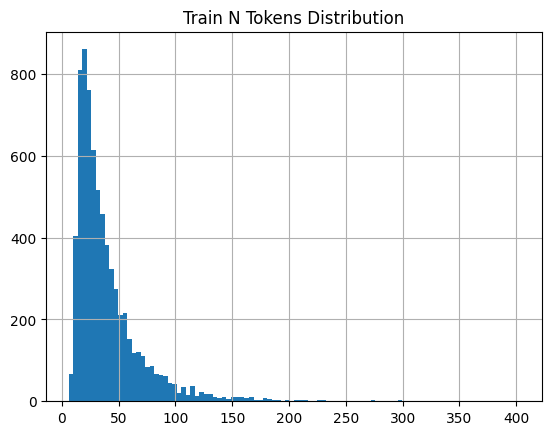

0.95 Quantile of N tokens: 98.0


In [84]:
# Here we want to figure out empirically max_length
tokenizer = get_tokenizer('basic_english')
train_n_tokens = merged_train_stats["clean_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [85]:
SEQ_LEN = 98   

In [120]:
def torch_loop(
    dataloader,
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cuda",
    skip_concat=False
    
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label_wording = []
    all_predicted_label_content = []
    all_losses_wording = []
    all_losses_content = []
    all_targets_wording = []
    all_targets_content = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, wording_target, content_target in tqdm(dataloader):
            text = text.to(device)
            wording_target = wording_target.to(device)
            content_target = content_target.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path for wording
            predicted_label_wording = inp_model(text)
        
            # 1.2 Compute Cost function (part of Forward path) for wording
            loss_wording = inp_criterion(predicted_label_wording, wording_target.view(-1, 1))

            # 1.3 Compute Forward path for content
            # Assuming you have a separate model for the content task
            predicted_label_content = inp_model(text)  # Modify this part accordingly
        
            # 1.4 Compute Cost function (part of Forward path) for content
            loss_content = inp_criterion(predicted_label_content, content_target.view(-1, 1))  # Modify this part accordingly

            if mode == "train":
                # 2. Compute Backward path for wording
                loss_wording.mean().backward()
                # 3. Apply gradient descent `on steroids` for wording
                optimizer.step()

                # 4. Compute Backward path for content
                loss_content.mean().backward()
                # 5. Apply gradient descent `on steroids` for content
                optimizer.step()

            # Accumulate stats for wording
            all_predicted_label_wording.append(torch.sigmoid(predicted_label_wording.detach()).cpu().numpy())
            all_losses_wording.append(loss_wording.detach().cpu().numpy().reshape(-1, 1))
            all_targets_wording.append(wording_target.detach().cpu().numpy().reshape(-1, 1))

            # Accumulate stats for content
            all_predicted_label_content.append(torch.sigmoid(predicted_label_content.detach()).cpu().numpy())
            all_losses_content.append(loss_content.detach().cpu().numpy().reshape(-1, 1))
            all_targets_content.append(content_target.detach().cpu().numpy().reshape(-1, 1))

    if not skip_concat:
        all_predicted_label_wording = np.concatenate(all_predicted_label_wording)
        all_losses_wording = np.concatenate(all_losses_wording)
        all_targets_wording = np.concatenate(all_targets_wording)
    
        all_predicted_label_content = np.concatenate(all_predicted_label_content)
        all_losses_content = np.concatenate(all_losses_content)
        all_targets_content = np.concatenate(all_targets_content)

    return (all_predicted_label_wording, all_losses_wording, all_targets_wording,
            all_predicted_label_content, all_losses_content, all_targets_content)


In [87]:
from sklearn.model_selection import GroupKFold

n_splits = 4  

# Assuming you have a 'group' column in your DataFrame specifying the group for each sample
group_kfold = GroupKFold(n_splits=n_splits)

folds_train_test_ids = []
for train_indices, test_indices in group_kfold.split(merged_train_stats, groups=merged_train_stats['prompt_id']):
    folds_train_test_ids.append((train_indices, test_indices))


train_dataset = TextDataset(
    texts=merged_train_stats.iloc[folds_train_test_ids[0][0]]["clean_text"].to_list(),
    targets={
        'wording': merged_train_stats.iloc[folds_train_test_ids[0][0]]["wording"].values,
        'content': merged_train_stats.iloc[folds_train_test_ids[0][0]]["content"].values,
    },
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=train_dataset.collate_fn
)


valid_dataset = TextDataset(
    texts=merged_train_stats.iloc[folds_train_test_ids[0][1]]["clean_text"].to_list(),
    targets={
        'wording': merged_train_stats.iloc[folds_train_test_ids[0][1]]["wording"].values,
        'content': merged_train_stats.iloc[folds_train_test_ids[0][1]]["content"].values,
    },
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True,
    collate_fn=valid_dataset.collate_fn
)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [88]:
def comp_metric(actual: np.ndarray, predicted: np.ndarray) -> float:
    RMSE_arr = math.sqrt(((actual-predicted)**2).mean())
    return np.mean(RMSE_arr)

In [89]:


n_epochs = 20

train_all_epoch_wording_labels = []
train_all_epoch_wording_losses = []
train_all_epoch_wording_targets = []

train_all_epoch_content_labels = []
train_all_epoch_content_losses = []
train_all_epoch_content_targets = []

valid_all_epoch_wording_labels = []
valid_all_epoch_wording_losses = []
valid_all_epoch_wording_targets = []

valid_all_epoch_content_labels = []
valid_all_epoch_content_losses = []
valid_all_epoch_content_targets = []

valid_metrics = []
train_metrics = []

best_metric = -np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # Train phase
    print("Train phase")
    train_wording_epoch_labels, train_wording_epoch_losses, train_wording_epoch_targets, \
    train_content_epoch_labels, train_content_epoch_losses, train_content_epoch_targets = torch_loop(
        dataloader=train_dataloader,
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # Compute and print train metrics
    train_wording_metric = comp_metric(
        train_wording_epoch_targets,
        train_wording_epoch_labels,
    )
    train_content_metric = comp_metric(
        train_content_epoch_targets,
        train_content_epoch_labels,
    )
    train_metric = (train_wording_metric + train_content_metric) / 2

    print("Train wording metric:", train_wording_metric)
    print("Train wording loss:", train_wording_epoch_losses.mean())
    
    print("Train content metric:", train_content_metric)
    print("Train content loss:", train_content_epoch_losses.mean())
    
    # Valid phase
    print("Valid phase")
    valid_wording_epoch_labels, valid_wording_epoch_losses, valid_wording_epoch_targets, \
    valid_content_epoch_labels, valid_content_epoch_losses, valid_content_epoch_targets = torch_loop(
        dataloader=valid_dataloader,
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # Compute and print valid metrics
    valid_wording_metric = comp_metric(
        valid_wording_epoch_targets,
        valid_wording_epoch_labels,
    )
    valid_content_metric = comp_metric(
        valid_content_epoch_targets,
        valid_content_epoch_labels,
    )
    valid_metric = (valid_wording_metric + valid_content_metric) / 2

    print("Valid wording metric:", valid_wording_metric)
    print("Valid wording loss:", valid_wording_epoch_losses.mean())
    
    print("Valid content metric:", valid_content_metric)
    print("Valid content loss:", valid_content_epoch_losses.mean())
    
    # Update learning rate
    scheduler.step(valid_metric)
    
    # Save best model
    if valid_metric > best_metric:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    
    # Accumulate all stats
    train_all_epoch_wording_labels.append(train_wording_epoch_labels)
    train_all_epoch_wording_losses.append(train_wording_epoch_losses)
    train_all_epoch_wording_targets.append(train_wording_epoch_targets)
    
    train_all_epoch_content_labels.append(train_content_epoch_labels)
    train_all_epoch_content_losses.append(train_content_epoch_losses)
    train_all_epoch_content_targets.append(train_content_epoch_targets)
   
    valid_all_epoch_wording_labels.append(valid_wording_epoch_labels)
    valid_all_epoch_wording_losses.append(valid_wording_epoch_losses)
    valid_all_epoch_wording_targets.append(valid_wording_epoch_targets)
                                           
    valid_all_epoch_content_labels.append(valid_content_epoch_labels)
    valid_all_epoch_content_losses.append(valid_content_epoch_losses)
    valid_all_epoch_content_targets.append(valid_content_epoch_targets)
    
    valid_metrics.append(valid_metric)
    train_metrics.append(train_metric)


Starting Epoch 1
Train phase


100%|██████████| 159/159 [00:03<00:00, 49.45it/s] 


Train wording metric: 1.1072875787486673
Train wording loss: 0.87033916
Train content metric: 1.0949265282947465
Train content loss: 0.6508656
Valid phase


100%|██████████| 65/65 [00:01<00:00, 38.06it/s]


Valid wording metric: 1.1762829087424234
Valid wording loss: 0.72576344
Valid content metric: 1.0683400712021458
Valid content loss: 0.4786336
Starting Epoch 2
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.14it/s] 


Train wording metric: 1.0980579550722487
Train wording loss: 0.80959404
Train content metric: 1.0853870011935487
Train content loss: 0.5886372
Valid phase


100%|██████████| 65/65 [00:01<00:00, 39.88it/s]


Valid wording metric: 1.1996168041340802
Valid wording loss: 0.7993314
Valid content metric: 1.095175005544952
Valid content loss: 0.5670782
Starting Epoch 3
Train phase


100%|██████████| 159/159 [00:02<00:00, 57.39it/s] 


Train wording metric: 1.0911875544593412
Train wording loss: 0.75523657
Train content metric: 1.0809025024147934
Train content loss: 0.5569277
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.69it/s]


Valid wording metric: 1.1458240797651769
Valid wording loss: 0.68533695
Valid content metric: 1.0393238169259105
Valid content loss: 0.4855299
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Starting Epoch 4
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.00it/s] 


Train wording metric: 1.07752105825075
Train wording loss: 0.667006
Train content metric: 1.0732039218290645
Train content loss: 0.5239698
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.44it/s]


Valid wording metric: 1.1414686766882982
Valid wording loss: 0.5981258
Valid content metric: 1.0355204967015623
Valid content loss: 0.4042608
Epoch 00004: reducing learning rate of group 0 to 2.5000e-04.
Starting Epoch 5
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.86it/s] 


Train wording metric: 1.063945460219544
Train wording loss: 0.57921195
Train content metric: 1.06305091263366
Train content loss: 0.47100848
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.62it/s]


Valid wording metric: 1.1437171410181595
Valid wording loss: 0.54295397
Valid content metric: 1.0415052797547202
Valid content loss: 0.37960723
Epoch 00005: reducing learning rate of group 0 to 1.2500e-04.
Starting Epoch 6
Train phase


100%|██████████| 159/159 [00:02<00:00, 55.01it/s] 


Train wording metric: 1.0563760309815806
Train wording loss: 0.52804154
Train content metric: 1.0562296013301338
Train content loss: 0.4260908
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.13it/s]


Valid wording metric: 1.1262291445478814
Valid wording loss: 0.51079124
Valid content metric: 1.0237129364943207
Valid content loss: 0.3617319
Epoch 00006: reducing learning rate of group 0 to 6.2500e-05.
Starting Epoch 7
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.98it/s] 


Train wording metric: 1.0505527403863415
Train wording loss: 0.49570385
Train content metric: 1.0520529160335832
Train content loss: 0.41286254
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.58it/s]


Valid wording metric: 1.1235744132917853
Valid wording loss: 0.5003926
Valid content metric: 1.0213596712800885
Valid content loss: 0.35720295
Epoch 00007: reducing learning rate of group 0 to 3.1250e-05.
Starting Epoch 8
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.13it/s] 


Train wording metric: 1.0480651922114599
Train wording loss: 0.4836944
Train content metric: 1.048909217924604
Train content loss: 0.39891
Valid phase


100%|██████████| 65/65 [00:01<00:00, 39.37it/s]


Valid wording metric: 1.1237307382021218
Valid wording loss: 0.4941758
Valid content metric: 1.0215881761724004
Valid content loss: 0.35153073
Epoch 00008: reducing learning rate of group 0 to 1.5625e-05.
Starting Epoch 9
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.21it/s] 


Train wording metric: 1.0478141898879096
Train wording loss: 0.4808451
Train content metric: 1.048696555866236
Train content loss: 0.39569464
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.57it/s]


Valid wording metric: 1.1174360412284308
Valid wording loss: 0.49295524
Valid content metric: 1.0150041883598315
Valid content loss: 0.35454044
Epoch 00009: reducing learning rate of group 0 to 7.8125e-06.
Starting Epoch 10
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.04it/s] 


Train wording metric: 1.045656377454955
Train wording loss: 0.47858995
Train content metric: 1.0465979707754718
Train content loss: 0.39320666
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.61it/s]


Valid wording metric: 1.1220112412377459
Valid wording loss: 0.48985988
Valid content metric: 1.0198496471180178
Valid content loss: 0.34845456
Epoch 00010: reducing learning rate of group 0 to 3.9063e-06.
Starting Epoch 11
Train phase


100%|██████████| 159/159 [00:02<00:00, 58.25it/s] 


Train wording metric: 1.0475770674330405
Train wording loss: 0.476422
Train content metric: 1.0486171517327967
Train content loss: 0.39187554
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.70it/s]


Valid wording metric: 1.1203710373145839
Valid wording loss: 0.48902547
Valid content metric: 1.0180878341944597
Valid content loss: 0.34831128
Epoch 00011: reducing learning rate of group 0 to 1.9531e-06.
Starting Epoch 12
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.10it/s] 


Train wording metric: 1.048650971694341
Train wording loss: 0.4811749
Train content metric: 1.0490976338984637
Train content loss: 0.39269757
Valid phase


100%|██████████| 65/65 [00:01<00:00, 39.77it/s]


Valid wording metric: 1.1193489027362398
Valid wording loss: 0.48893285
Valid content metric: 1.0170468281455232
Valid content loss: 0.34927854
Epoch 00012: reducing learning rate of group 0 to 9.7656e-07.
Starting Epoch 13
Train phase


100%|██████████| 159/159 [00:03<00:00, 52.41it/s] 


Train wording metric: 1.0457680386732275
Train wording loss: 0.47032234
Train content metric: 1.0471522405386489
Train content loss: 0.3903088
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.82it/s]


Valid wording metric: 1.1193841532764819
Valid wording loss: 0.48882005
Valid content metric: 1.0170882614643537
Valid content loss: 0.3491832
Epoch 00013: reducing learning rate of group 0 to 4.8828e-07.
Starting Epoch 14
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.56it/s] 


Train wording metric: 1.0463895099013463
Train wording loss: 0.47486553
Train content metric: 1.0471137045116383
Train content loss: 0.3851172
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.87it/s]


Valid wording metric: 1.1193950157569823
Valid wording loss: 0.48876262
Valid content metric: 1.0171042600169506
Valid content loss: 0.34916234
Epoch 00014: reducing learning rate of group 0 to 2.4414e-07.
Starting Epoch 15
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.63it/s] 


Train wording metric: 1.0462968852705097
Train wording loss: 0.46992713
Train content metric: 1.0480816847074534
Train content loss: 0.3874711
Valid phase


100%|██████████| 65/65 [00:01<00:00, 39.83it/s]


Valid wording metric: 1.1193758466026218
Valid wording loss: 0.48873666
Valid content metric: 1.0170868549861571
Valid content loss: 0.3491776
Epoch 00015: reducing learning rate of group 0 to 1.2207e-07.
Starting Epoch 16
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.89it/s] 


Train wording metric: 1.0465840177240409
Train wording loss: 0.47439104
Train content metric: 1.0481986033755866
Train content loss: 0.38920304
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.18it/s]


Valid wording metric: 1.1193448025258028
Valid wording loss: 0.48873505
Valid content metric: 1.0170546226611328
Valid content loss: 0.3492024
Epoch 00016: reducing learning rate of group 0 to 1.0000e-07.
Starting Epoch 17
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.59it/s] 


Train wording metric: 1.0461680174397447
Train wording loss: 0.46706548
Train content metric: 1.0474089783700902
Train content loss: 0.38782942
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.70it/s]


Valid wording metric: 1.1193330343059378
Valid wording loss: 0.48872575
Valid content metric: 1.017043604832135
Valid content loss: 0.34921452
Starting Epoch 18
Train phase


100%|██████████| 159/159 [00:02<00:00, 59.25it/s] 


Train wording metric: 1.047082624201162
Train wording loss: 0.48442233
Train content metric: 1.048548087414878
Train content loss: 0.39739558
Valid phase


100%|██████████| 65/65 [00:01<00:00, 40.23it/s]


Valid wording metric: 1.119354919900986
Valid wording loss: 0.48871955
Valid content metric: 1.0170691566359624
Valid content loss: 0.34922037
Starting Epoch 19
Train phase


100%|██████████| 159/159 [00:02<00:00, 60.66it/s] 


Train wording metric: 1.0460522963249632
Train wording loss: 0.4758535
Train content metric: 1.0486639878258397
Train content loss: 0.3879596
Valid phase


100%|██████████| 65/65 [00:01<00:00, 39.69it/s]


Valid wording metric: 1.1193233959884556
Valid wording loss: 0.48871773
Valid content metric: 1.0170371581747115
Valid content loss: 0.34925172
Starting Epoch 20
Train phase


100%|██████████| 159/159 [00:02<00:00, 56.96it/s] 


Train wording metric: 1.0461694987693602
Train wording loss: 0.47949496
Train content metric: 1.0482206094680577
Train content loss: 0.3935091
Valid phase


100%|██████████| 65/65 [00:01<00:00, 34.51it/s]

Valid wording metric: 1.1193004979953427
Valid wording loss: 0.48872283
Valid content metric: 1.0170146531593858
Valid content loss: 0.34928864


In [104]:
# best_model_state_dict

# We see that there are some problems with our model because of unusual loss and absence of any improvements. It may be caosed by inappropirate learning rate so our optimizer doesn`t converege. We should try to tune hyperparameters in order to improve our model(maybe tuning dropout  rate will help us get rid of overfitting and making learning rate smaller will help our optimizer to converge)

In [91]:
# def objective(trial):
    

    
#     # Generate the hyperparameters.
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
#     lr = trial.suggest_float("lr", 1e-5, 1e-3)
#     rnn_channels = trial.suggest_int('rnn_channels', 64, 1024)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)
    
#     # Create a new model instance with suggested hyperparameters
#     model = nn_model
    
#     # Define the optimizer
#     optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
#     # Define the learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

#     # Define the loss function
#     criterion = nn.MSELoss(reduction="none")  # Mean Squared Error for regression
    
#     # Training of the model.
#     n_epochs = 20

#     best_metric = -np.inf
#     best_model_state_dict = None

#     for epoch in range(1, n_epochs + 1):
#         print(f"Starting Epoch {epoch}")
        
#         # Train phase
#         train_wording_epoch_labels, train_wording_epoch_losses, train_wording_epoch_targets, \
#         train_content_epoch_labels, train_content_epoch_losses, train_content_epoch_targets = torch_loop(
#             dataloader=train_dataloader,
#             inp_model=model,
#             inp_optimizer=optimizer,
#             inp_criterion=criterion,
#             device=global_device,
#             mode="train"
#         )
        
#         # Compute and print train metrics
#         train_wording_metric = comp_metric(
#             train_wording_epoch_targets,
#             train_wording_epoch_labels,
#         )
#         train_content_metric = comp_metric(
#             train_content_epoch_targets,
#             train_content_epoch_labels,
#         )
#         train_metric = (train_wording_metric + train_content_metric) / 2

#         print("Train wording metric:", train_wording_metric)
#         print("Train wording MSE loss:", train_wording_epoch_losses.mean())

#         print("Train content metric:", train_content_metric)
#         print("Train content MSE loss:", train_content_epoch_losses.mean())
        
#         # Valid phase
#         valid_wording_epoch_labels, valid_wording_epoch_losses, valid_wording_epoch_targets, \
#         valid_content_epoch_labels, valid_content_epoch_losses, valid_content_epoch_targets = torch_loop(
#             dataloader=valid_dataloader,
#             inp_model=model,
#             inp_optimizer=optimizer,
#             inp_criterion=criterion,
#             device=global_device,
#             mode="eval"
#         )
        
#         # Compute and print valid metrics
#         valid_wording_metric = comp_metric(
#             valid_wording_epoch_targets,
#             valid_wording_epoch_labels,
#         )
#         valid_content_metric = comp_metric(
#             valid_content_epoch_targets,
#             valid_content_epoch_labels,
#         )
#         valid_metric = (valid_wording_metric + valid_content_metric) / 2

#         print("Valid wording metric:", valid_wording_metric)
#         print("Valid wording MSE loss:", valid_wording_epoch_losses.mean())

#         print("Valid content metric:", valid_content_metric)
#         print("Valid content MSE loss:", valid_content_epoch_losses.mean())
        
#         # Update learning rate
#         scheduler.step(valid_metric)
        
#         # Save best model
# #         if valid_metric > best_metric:
# #             best_metric = valid_metric
# #             best_model_state_dict = deepcopy(model.state_dict())

#               # Save best model
#         if valid_metric > best_metric:
#             best_metric = valid_metric
#             best_model_state_dict = deepcopy(nn_model.state_dict())
#             best_hparams = {
#                 "optimizer_name": optimizer_name,
#                 "lr": lr,
#                 "rnn_channels": rnn_channels,
#                 "dropout_rate": dropout_rate
#             }

#     # Use the best model state
# #     model.load_state_dict(best_model_state_dict)

#     torch.save({
#         'model_state_dict': best_model_state_dict,
#         'hparams': best_hparams
#     }, 'best_model.pth')

    
#     return best_metric


In [92]:
# import optuna
# import torch.optim as optim

In [93]:
# study = optuna.create_study(directions=["minimize"])
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))

# trials = sorted(study.best_trials, key=lambda t: t.values)

# for trial in trials:
#     print("  Trial #{}".format(trial.number))
#     print("    Params: {}".format(trial.params))

In [94]:
# print('Bets trial value:', study.best_trial.value)
# print("Best trial:")
# trial = study.best_trial

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# Submission part


In [ ]:
# Load the saved model state and hyperparameters
# checkpoint = torch.load('best_rnn_model.pth')
# best_model_state_dict = checkpoint['model_state_dict']
# best_hparams = checkpoint['hparams']


# nn_model = UniversalRNN(
#     num_embeddings=len(vocab),
#     rnn_channels=best_hparams['rnn_channels'],
#     out_channels=1,
#     average_type="mean",
#     bidirectional=True
#     ,dropout_rate = best_hparams['dropout_rate']
# ).to(global_device)

# criterion = torch.torch.nn.MSELoss()
# optimizer = torch.optim.Adam(nn_model.parameters(), lr=best_params['lr'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [148]:
merged_test = pd.merge(summaries_test, prompts_test, on="prompt_id", how="inner")
merged_test["clean_text"] = merged_test.apply(lambda row: process_text(row["text"], select_stopwordset("basic")), axis=1)
merged_test_stats = feature_engineer(merged_test)

In [149]:
merged_test_stats[["wording", "content"]] = [0,0]

In [154]:
test_torch_dataset = TextDataset(
    texts=merged_test_stats["clean_text"].to_list(),
    targets=merged_test_stats[["wording", "content"]],
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=SEQ_LEN,
    # trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=test_torch_dataset.collate_fn
)
iter = 0 
for batch in test_torch_dataset:
    break

print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
[142, 37, 158]
`Target` batch:
0


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [142]:
# # load trained model
# nn_model.load_state_dict(best_model_state_dict)

# # inference on test data
# test_wording_labels, test_wording_losses, test_wording_targets,test_content_labels, test_content_losses, test_content_targets = torch_loop(
#     dataloader=test_torch_dataloader, 
#     inp_model=nn_model,
#     inp_optimizer=optimizer,
#     inp_criterion=criterion,
#     device=global_device,
#     mode="eval",
#     skip_concat=True
# )

0it [00:01, ?it/s]


In [152]:
# # Create submission dataframe
# submission = pd.DataFrame(merged_test_stats['student_id'])
# submission['content'] = test_content_labels
# submission['wording'] = test_wording_labels
# submission.head()

In [ ]:
# # Save submission
# submission.to_csv('submission.csv',index=False)
# display(pd.read_csv('submission.csv'))